<a href="https://colab.research.google.com/github/anitaesmaeilian/EduHPC-25/blob/main/tomato_leaf_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 0: Clean Slate Setup

The following cell is designed to ensure you start with a **clean slate** when running this notebook multiple times in the same runtime session.

It deletes all files and folders in the current working directory to prevent any leftover files from previous runs interfering with your current run.

Run this cell especially before the **second or third rounds** of executing the notebook to avoid file conflicts or duplicates.


In [3]:
import os
import shutil

current_dir = '.'

for item in os.listdir(current_dir):
    item_path = os.path.join(current_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.remove(item_path)  # Remove file or symlink
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove directory recursively
        print(f"Deleted: {item_path}")
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

Deleted: ./.config
Deleted: ./0a9ce4eb-961b-4f11-a06f-2946cfd0d562___UF.GRC_YLCV_Lab 02233.JPG
Deleted: ./__MACOSX
Deleted: ./tomato_dataset
Deleted: ./tomato_dataset (1).zip
Deleted: ./tomato_dataset.zip
Deleted: ./sample_data


### 📥 Step 1: Upload and Unzip the Dataset

In this step, you will upload the compressed dataset file `tomato_dataset.zip` from your local computer to Google Colab.

- The file upload dialog will appear after running the cell—select your `tomato_dataset.zip` file.
- Once uploaded, the dataset will be unzipped quietly (`-q` flag suppresses output) into the current working directory.
- After this step, the dataset folder will be available in Colab’s file system for further processing.

💡 Make sure your zipped dataset contains subfolders for each class (e.g., `healthy`, `late_blight`, etc.) directly inside the main folder.

In [4]:
from google.colab import files
uploaded = files.upload()  # Select tomato_dataset.zip from your computer

!unzip -q tomato_dataset.zip  # Unzip the uploaded file quietly

Saving tomato_dataset.zip to tomato_dataset.zip


### 🧹 Step 2: Clean the Uploaded Dataset Folder

Before using the dataset for training, we need to make sure the directory is **clean and free from unwanted files** that may have been included when compressing the dataset (especially on macOS systems).

#### Why this step matters:
- Nested folders (e.g., another `dataset` folder inside `tomato_dataset`) or zip files can cause incorrect class labeling.
- System files like `.DS_Store` or `__MACOSX` are automatically generated by macOS and **can break directory parsing** during image loading.

#### What this cell does:
- Prints the contents of the dataset directory before and after cleaning.
- Deletes:
  - Any nested zip file accidentally copied inside the dataset folder.
  - Any unwanted nested folder (`dataset/`) with leftover images.
  - System files: `.DS_Store` and `__MACOSX`.

💡 This step ensures that your image dataset has **only clean, labeled subfolders** (e.g., `healthy`, `late_blight`, etc.), each containing relevant image files, which is required for `image_dataset_from_directory()` to work properly.

In [5]:
import os
import shutil

base_path = 'tomato_dataset'

# Check what's inside tomato_dataset folder
print("Initial contents:", os.listdir(base_path))

# Delete unwanted nested zip file
nested_zip = os.path.join(base_path, 'dataset.zip')
if os.path.exists(nested_zip):
    os.remove(nested_zip)
    print(f"Deleted nested zip file: {nested_zip}")

# Delete unwanted nested folder with few images (looks like leftover)
nested_folder = os.path.join(base_path, 'dataset')
if os.path.exists(nested_folder):
    shutil.rmtree(nested_folder)
    print(f"Deleted nested folder: {nested_folder}")

# Delete macOS system file if exists
ds_store = os.path.join(base_path, '.DS_Store')
if os.path.exists(ds_store):
    os.remove(ds_store)
    print(f"Deleted .DS_Store file: {ds_store}")

# Delete macOS system file if exists
ds_store = os.path.join(base_path, '__MACOSX')
if os.path.exists(ds_store):
    os.remove(ds_store)
    print(f"Deleted .DS_Store file: {ds_store}")

# Final folder contents after cleanup
print("Cleaned contents:", os.listdir(base_path))

Initial contents: ['septoria_leaf_spot', 'late_blight', '.DS_Store', 'yellow_leaf_curl_virus', 'healthy']
Deleted .DS_Store file: tomato_dataset/.DS_Store
Cleaned contents: ['septoria_leaf_spot', 'late_blight', 'yellow_leaf_curl_virus', 'healthy']


In this step, we load the tomato leaf image dataset from the `tomato_dataset` directory. The dataset contains four categories of tomato leaf conditions: `healthy`, `late_blight`, `septoria_leaf_spot`, and `yellow_leaf_curl_virus`. We use TensorFlow's `image_dataset_from_directory()` function to automatically load, label, resize, and batch the images.

- **Training/Validation Split**: 80% of the images are used for training, and 20% for validation.
- **Image Size**: All images are resized to 224x224 pixels.
- **Batch Size**: We load images in batches of 16 for efficient training.
- **Class Names**: The folder names are used to generate class labels.
- **Batch Preview**: We print the shape of one batch of images and the corresponding label indices to confirm the data is loaded correctly.

This helps us verify that:
- The dataset is correctly structured and split.
- The model input shape is as expected.
- The labels match the class folders.

Next, we’ll normalize the images and build our classifier.


In [6]:
import tensorflow as tf

batch_size = 16
img_height = 224
img_width = 224
dataset_path = "/content/tomato_dataset"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# **Get class names now, BEFORE any dataset transformation**
class_names = train_ds.class_names
print("Class names:", class_names)

# Check one batch
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch: {labels.numpy()}")

Found 200 files belonging to 4 classes.
Using 160 files for training.
Found 200 files belonging to 4 classes.
Using 40 files for validation.
Class names: ['healthy', 'late_blight', 'septoria_leaf_spot', 'yellow_leaf_curl_virus']
Image batch shape: (16, 224, 224, 3)
Label batch: [0 0 1 3 3 3 2 2 0 1 0 3 0 2 0 2]


### 🧼 Step 4: Normalize the Images

Neural networks train better when input values are within a standard range. Our image pixels currently range from 0 to 255, so we normalize them to a 0–1 range by dividing each pixel by 255.

- We use `layers.Rescaling(1./255)` from TensorFlow to create a normalization layer.
- Then, we apply this layer to each image in the training and validation datasets using the `.map()` function.
- This operation keeps the labels unchanged while transforming the image data.

📌 **Why this is important**: Normalized inputs help models train faster and more reliably.


In [7]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


### 🧠 Step 5: Build the Image Classification Model (Transfer Learning)

We use **MobileNetV2**, a lightweight and efficient pretrained model, as the feature extractor. This is a form of **transfer learning**, where we reuse a model trained on a large dataset (ImageNet) to help classify tomato leaf diseases.

#### Key parts of this model:
- `MobileNetV2`: Pretrained convolutional base (without the top dense layers) to extract image features.
- `include_top=False`: We remove the original classifier layer to add our own.
- `base_model.trainable = False`: We **freeze** the base model so only our custom layers are trained.
- `GlobalAveragePooling2D()`: Reduces the feature maps to a single vector per image.
- `Dropout(0.3)`: Adds regularization to prevent overfitting.
- `Dense(...)`: Final classification layer with a softmax activation to output class probabilities.

#### Compilation:
- **Optimizer**: Adam – adaptive and efficient.
- **Loss Function**: `sparse_categorical_crossentropy` – for multi-class classification using integer labels.
- **Metric**: Accuracy – to monitor performance.

Finally, `model.summary()` gives a readable overview of the model architecture.


In [8]:
from tensorflow.keras import models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze pretrained base

num_classes = len(class_names)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 🏋️ Step 6: Train the Model

Now that our model is built and compiled, we train it using our prepared datasets.

- **`epochs = 15`**: The model will go through the entire training dataset 15 times.
- **`model.fit(...)`**: This function trains the model using the training dataset and evaluates it on the validation dataset after each epoch.
- **`history`**: This stores the training and validation loss and accuracy for each epoch, which we can later use to visualize the model’s performance over time.

⏳ This step might take a few minutes depending on the dataset and runtime.

In [9]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 979ms/step - accuracy: 0.3267 - loss: 1.4023 - val_accuracy: 0.7250 - val_loss: 0.8849
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 630ms/step - accuracy: 0.6858 - loss: 0.8794 - val_accuracy: 0.8750 - val_loss: 0.5927
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - accuracy: 0.8697 - loss: 0.5160 - val_accuracy: 0.9750 - val_loss: 0.4393
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step - accuracy: 0.9102 - loss: 0.3656 - val_accuracy: 0.9750 - val_loss: 0.3548
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.9223 - loss: 0.3664 - val_accuracy: 1.0000 - val_loss: 0.2780
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 773ms/step - accuracy: 0.9349 - loss: 0.2747 - val_accuracy: 0.9750 - val_loss: 0.2559
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.9579 - loss: 0.2201 - val_accuracy: 1.0000 - val_loss: 0.2139
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.9496 - loss: 0.2133 - val_accuracy

### 📈 Step 7: Visualize Training and Validation Performance

After training, it's important to **analyze how well the model performed** over the epochs. We extract the accuracy and loss values stored in the `history` object and plot them using `matplotlib`.

#### Two plots are shown:
- **Training vs. Validation Accuracy**: Helps us see if the model is improving and whether it’s overfitting (training accuracy much higher than validation).
- **Training vs. Validation Loss**: Useful for checking if the model is converging properly.

These plots help us decide if we need to adjust hyperparameters, use more data, or try techniques like data augmentation or fine-tuning.

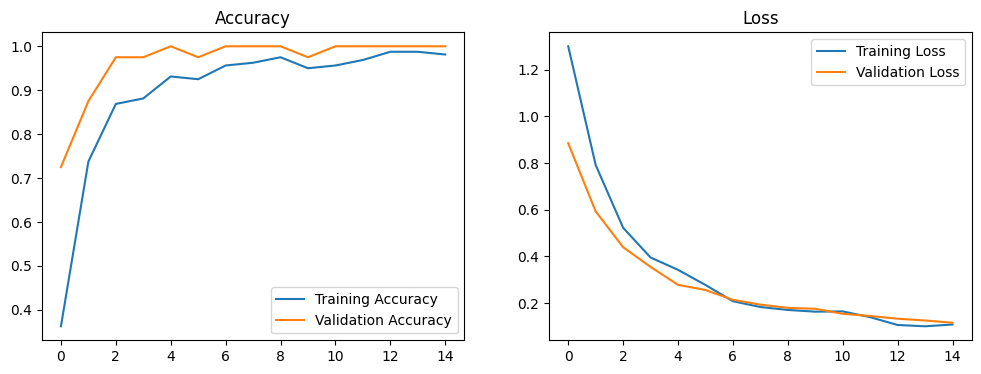

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

### 🔍 Step 8: Upload and Test a New Image

This step allows you to **upload a tomato leaf image** from your computer and use the trained model to **predict the disease class**.

#### Here's what happens:
1. **Image Upload**: A dialog box will pop up for you to select an image file.
2. **Preprocessing**:
   - Resize to 224×224 pixels.
   - Convert to a NumPy array and normalize pixel values (between 0 and 1).
   - Expand dimensions to fit the model’s expected input shape.
3. **Prediction**:
   - The model outputs a probability for each of the four classes.
   - The class with the highest probability is selected as the prediction.
4. **Output**:
   - Prints the predicted class and confidence.
   - Displays the uploaded image alongside the prediction.

📌 Make sure the image clearly shows a tomato leaf and is similar in format to the training images for best results.


Saving 0a4b3cde-c83a-4c83-b037-010369738152___RS_Late.B 6985.JPG to 0a4b3cde-c83a-4c83-b037-010369738152___RS_Late.B 6985.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: late_blight (95.01% confidence)


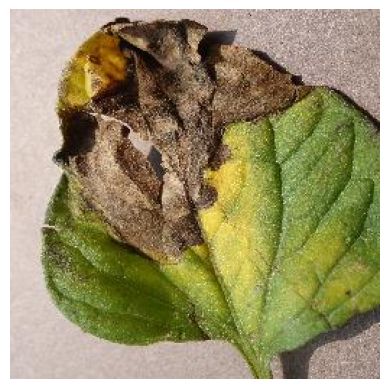

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

# Upload a test image from your computer
uploaded = files.upload()

# Get uploaded filename (assumes only one file uploaded)
test_image_path = list(uploaded.keys())[0]

# Function to preprocess the image
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    return img_array

# Preprocess the image
img = preprocess_img(test_image_path)

# Predict class probabilities
predictions = model.predict(img)
predicted_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_index]
confidence = predictions[0][predicted_index]

print(f"Predicted class: {predicted_class} ({confidence*100:.2f}% confidence)")

# Display the image
plt.imshow(image.load_img(test_image_path))
plt.axis('off')
plt.show()